# Algorithmic Development for Reconstructing Surface Ocean pCO$_2$
## Using SHAP values to evaluate models

This project focuses on using the existing scripts to develop an ML model for reconstructing surface ocean pCO$_2$. It then conducts a SHAP value analysis to first validate that trends in the features make physical sense. It then also investigates connections with model inaccuracies with their respective features. Overall this methodology can be used to validate the physical nature of models in addition to identifying what kind of additional data needs to be collected to improve them.
 

# Part 1: Setting up workspace

In [1]:
#@title Mount drive
from google.colab import drive
drive.mount('/content/drive')
root_dir = "/content/drive/MyDrive/Colab Notebooks/LEAP Colab Notebooks/Project 3/" # change it to your own project dir

Mounted at /content/drive


In [2]:
#@title install the packages
!pip install SkillMetrics
!pip install cmocean
!pip3 install cartopy
!pip uninstall -y shapely
!pip install shapely --no-binary shapely
!pip install shap


     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 149 kB 10.8 MB/s 
     |████████████████████████████████| 223 kB 5.0 MB/s 
     |████████████████████████████████| 10.8 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 26.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 28.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 28.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 44 kB 2.4 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12516288 sha256=540a67858ac0f3047b0bc108c53bc16635b6a

In [3]:
#@title import necessary packages
import os
import datetime
from pathlib import Path
from collections import defaultdict
import scipy
import random
import numpy as np
import xarray as xr
import pandas as pd
import joblib
import pickle
import skill_metrics as sm
import math
import seaborn as sns
import cmocean as cm            # really nice colorbars
import matplotlib.pyplot as plt # for making plots
import shap

# machine learning libraries
from sklearn.model_selection import train_test_split

In [4]:
#@title set current working directory
os.chdir(f"{root_dir}/lib/") 
print(os.getcwd())
#/content/drive/MyDrive/Colab Notebooks/LEAP Colab Notebooks/Project 3/lib/

/content/drive/MyDrive/Colab Notebooks/LEAP Colab Notebooks/Project 3/lib


In [5]:
#@title load user codes
# Python file with supporting functions
import pre
#import decompose as stl
from spatial_map import SpatialMap

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


# Part 2: Create reconstruction (with XGBoost)

In [6]:
#@title Define reconstruction experiment parameters
# define which ESM you will use, which member of the large ensemble, time range, and directories of the files
ens = 'CanESM2'
member = 'r4r3'

date_range_start = '1982-01-01T00:00:00.000000000'
date_range_end = '2017-01-31T00:00:00.000000000'

dates = pd.date_range(start=date_range_start, 
                      end=date_range_end,freq='MS') + np.timedelta64(14, 'D')

data_output_dir = f"{root_dir}/ESM/data/processed"
ensemble_dir_head = f"{root_dir}/ESM/" # Set this to where you have placed the raw data
xco2_path = f"{root_dir}/ESM/CESM001/member_001/XCO2_1D_mon_CESM001_native_198201-201701.nc" # xCO2(atmospheric CO2 mole fraction) is the same across members so only reference it once


reference_output_dir = f"{root_dir}/references"
model_output_dir = f"{root_dir}/models/trained"
recon_output_dir = f"{root_dir}/models/reconstructions"
other_output_dir = f"{root_dir}/models/performance_metrics"

approach = "xgb"
approach_output_dir = f"{other_output_dir}/{approach}"
param_fname = f"{approach_output_dir}/{approach}_best_params_dict.pickle"


In [7]:
#@title load and save data
# Uncomment to use new data
# load and save data
df = pre.create_inputs(ensemble_dir_head, ens, member, dates, xco2_path=xco2_path)
pre.save_clean_data(df, data_output_dir, ens, member)

start to import member data
finish importing member data
start to create feature
Starting data saving process
Save complete


In [8]:
#@title check data
data_dir = f"{data_output_dir}/{ens}/member_{member}"
fname = f"data_clean_2D_mon_{ens}_{member}_1x1_198201-201701.pkl"
file_path = f"{data_dir}/{fname}"

df = pd.read_pickle(file_path)
df=df.reset_index()
df["month"]=pd.DatetimeIndex(df["time"]).month
df["year"]=pd.DatetimeIndex(df["time"]).year
df.head()

,time,xlon,ylat,sss,SST,MLD,Chl,pCO2,socat_mask,mld_log,...,sst_anom,T0,T1,A,B,C,net_mask,xco2,month,year
0,1982-01-15,0.5,-89.5,0.0,NaN,NaN,0.0,0.0,0.0,NaN,...,NaN,0.966848,0.255353,-0.999962,0.000076,-0.008726,NaN,340.848541,1,1982
1,1982-01-15,0.5,-88.5,0.0,NaN,NaN,0.0,0.0,0.0,NaN,...,NaN,0.966848,0.255353,-0.999657,0.000228,-0.026176,NaN,340.848541,1,1982
2,1982-01-15,0.5,-87.5,0.0,NaN,NaN,0.0,0.0,0.0,NaN,...,NaN,0.966848,0.255353,-0.999048,0.000381,-0.043618,NaN,340.848541,1,1982
3,1982-01-15,0.5,-86.5,0.0,NaN,NaN,0.0,0.0,0.0,NaN,...,NaN,0.966848,0.255353,-0.998135,0.000533,-0.061046,NaN,340.848541,1,1982
4,1982-01-15,0.5,-85.5,0.0,NaN,NaN,0.0,0.0,0.0,NaN,...,NaN,0.966848,0.255353,-0.996917,0.000685,-0.078456,NaN,340.848541,1,1982


In [9]:
#@title set up for model training
# machine learning libraries
import sklearn            # machine-learning libary with many algorithms implemented
import xgboost as xgb     # extreme gradient boosting (XGB
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# =========================================
# Defining some inputs for the modeling process
# =========================================

# Train-validate-test split proportions
val_prop = .2
test_prop = .2

# Parameter grids
xg_param_grid = {"n_estimators":[2000, 3000, 4000],
                 "max_depth":[4,5,6]
                }

# Feature and target lists for feeding into the models
features_sel = ['sst_detrend', 'sst_anom', 'sss', 'sss_anom', 'mld_clim_log', 'chl_log', 'chl_anom', 'xco2', 'A', 'B', 'C', 'T0', 'T1',"month","year","xlon","ylat"]
target_sel = ['pCO2']

In [10]:
#@title data preparation. prepare the seen and unseen data. split the train and test data

data_dir = f"{data_output_dir}/{ens}/member_{member}"
fname = f"data_clean_2D_mon_{ens}_{member}_1x1_198201-201701.pkl"
file_path = f"{data_dir}/{fname}"
        
# Read in data, create some selection filters, produce a reduced dataframe
#df = pd.read_pickle(file_path)

# 816 represents 3 standard deviations above mean in SOCAT data -- observations above this threshold are unrealistic to observe in real-world data
recon_sel = (~df[features_sel+target_sel+['net_mask']].isna().any(axis=1)) & (df[target_sel] < 816).to_numpy().ravel()
sel = (recon_sel & (df['socat_mask'] == 1))
unseen_sel = (recon_sel & (df['socat_mask'] == 0))
        
 # Convert dataframe to numpy arrays, train/val/test split
from sklearn.model_selection import train_test_split
X_dev, X_test,y_dev, y_test=train_test_split(df.loc[sel,features_sel],df.loc[sel,target_sel], test_size=test_prop, shuffle=True)
X_train_val, X_val, y_train_val,y_val=train_test_split(X_dev, y_dev, test_size=val_prop/(1-test_prop), shuffle=True)

In [11]:
#@title Fit the model on train/validation data
features_sel_2 = ['sst_detrend', 'sst_anom', 'sss', 'sss_anom', 'mld_clim_log', 'chl_log', 'chl_anom', 'xco2', 'A', 'B', 'C', 'T0', 'T1']
model = XGBRegressor(n_jobs=1)
model.fit(X_train_val[features_sel_2], y_train_val)          

# Save the model
pre.save_model(model, model_output_dir, approach, ens, member)

[18:48:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Starting model saving process
Save complete


# Part 3: Results (SHAP values)

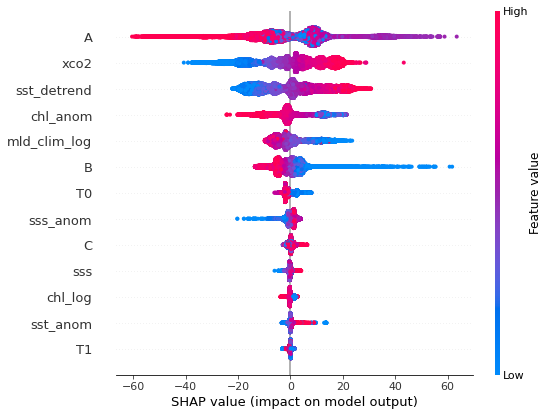

In [12]:
#@title Display shap values for XGBoost
import shap

shap_values_XGB = shap.TreeExplainer(model).shap_values(X_test[features_sel_2])
top_variables=X_test.columns[np.argsort(np.abs(shap_values_XGB).mean(0))[::-1]]
shap.summary_plot(shap_values_XGB, X_test[features_sel_2])

Here we can see that the heaviest feature dependence is on the variable A, which is just a function of latitude. Since latitude doesn't change over time, we will ignore it in our temporal analysis. EXPLAIN HOW TO READ THIS PLOT

In [13]:
#@title Appending time and coordinate columns to SHAP values for analyzing temporal and spatial shapely contribution of features
shap_values_XGB=pd.DataFrame(shap_values_XGB)
shap_values_XGB=shap_values_XGB.set_index(X_test.index)
shap_values_XGB.columns=[features_sel_2]
shap_values_XGB["month"]=X_test["month"]
shap_values_XGB["year"]=X_test["year"]
shap_values_XGB["xlon"]=X_test["xlon"]
shap_values_XGB["ylat"]=X_test["ylat"]
shap_values_XGB.columns = shap_values_XGB.columns.get_level_values(0)
shap_values_XGB.head()

# Assigning ocean basin wrt given the coordinate
def assign_ocean_basin(xlon,ylat):
  """
  Input: Takes in latitute and longitude
  Return: Ocean basin classified into Pacific, Indian Ocean, Atlantic, and Arctic
  """
  if ylat>=-66.5 and ylat<=-30:
    return "South Sub-tropical"
  elif ylat<-30 and ylat<30:
    return "Tropical"
  elif ylat<=66.5 and ylat>=30:
    return "North Sub-tropical"
  else:
    return "Pole area"

shap_values_XGB["Ocean Basin"] = shap_values_XGB.apply(lambda x: assign_ocean_basin(x.xlon, x.ylat), axis=1 )

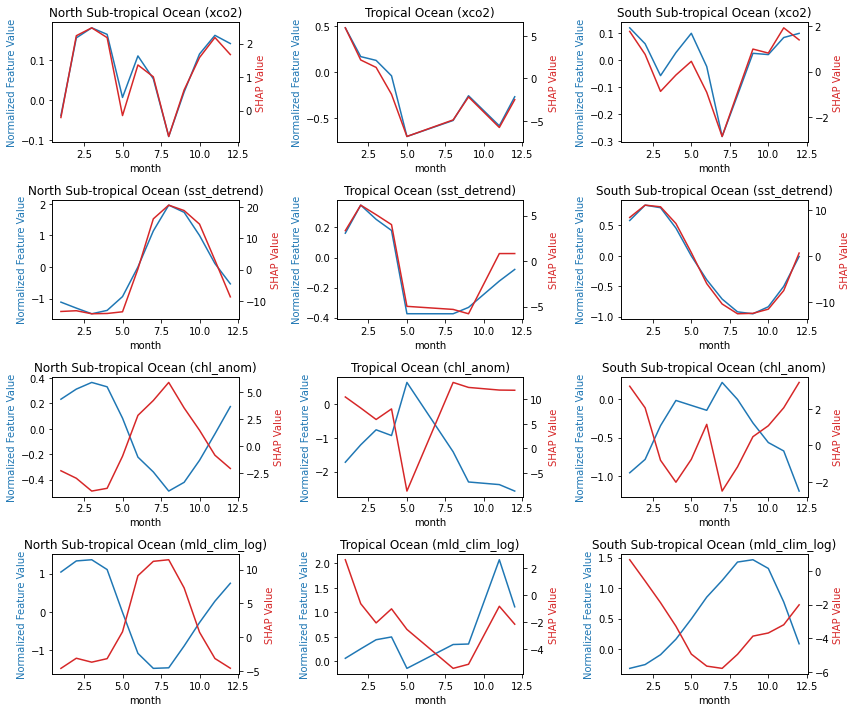

In [14]:
#@title Examining seasonal feature values and their importance in different regions
X_test_grouper=X_test
X_test_grouper=(X_test_grouper-X_test_grouper.mean())/X_test_grouper.std() # Normalizing to bring all the features to same observable scale
X_test_grouper["Ocean Basin"] = shap_values_XGB["Ocean Basin"]
X_test_grouper["month"] = shap_values_XGB["month"]


month_grouper=X_test_grouper.groupby(["month","Ocean Basin"])[features_sel_2[0]].mean().reset_index()

for feature in features_sel_2[1:]:
  month_grouper[feature]=X_test_grouper.groupby(["month","Ocean Basin"])[feature].mean().reset_index()[feature]

month_grouper_shap=shap_values_XGB.groupby(["month","Ocean Basin"])[features_sel_2[0]].mean().reset_index()

for feature in features_sel_2[1:]:
  month_grouper_shap[feature]=shap_values_XGB.groupby(["month","Ocean Basin"])[feature].mean().reset_index()[feature]


# Plot mean feature values of top variables over month
n_top_features=5 # specify the number of features to be analysed
ocean_basins=["North Sub-tropical", "Tropical","South Sub-tropical"]
features=['xco2','sst_detrend','chl_anom','mld_clim_log']
month_grouper_top_var=month_grouper[list(top_variables)[0:n_top_features]+["month","Ocean Basin"]]
month_grouper_top_var=month_grouper_top_var.set_index("month")
month_grouper_top_var_shap=month_grouper_shap[list(top_variables)[0:n_top_features]+["month","Ocean Basin"]]
month_grouper_top_var_shap=month_grouper_top_var_shap.set_index("month")
nrows=4
ncols=3
fig, axs = plt.subplots(nrows, ncols, figsize=(12, 10))
for row in range(nrows):
  for col in range(ncols):
    color = 'tab:blue'
    month_grouper_top_var.loc[month_grouper_top_var["Ocean Basin"]==ocean_basins[col], features[row]].plot.line(ax=axs[row,col], label=features[row],color=color)
    axs[row,col].set_ylabel('Normalized Feature Value', color=color)
    ax2 = axs[row,col].twinx()
    color = 'tab:red'
    month_grouper_top_var_shap.loc[month_grouper_top_var["Ocean Basin"]==ocean_basins[col], features[row]].plot.line(ax=ax2, label=features[row],color=color)
    ax2.set_ylabel('SHAP Value', color=color)
    axs[row,col].set_title(ocean_basins[col]+" Ocean "+'('+features[row]+')')
fig.tight_layout()
plt.show()



Above, we can identify some physically sensible trends. We see the strong seasonalities in temperature (and also mixed layer depth) in the north and south subtropics, as expected. We also notice that the temperatures and xCO2 variables basically have a direct relationship with how important it is in the model. I.e., the further a feature value deviates from average, the stronger of an impact it has on the model in the same direction. This makes sense for the variables xCO2 (dry air mixing ratio of atmospheric CO2) and SST since the higher the mixing ratio would imply more pCO2 in the water, and in the subtropics, the PCO2 content tracks the temperature (Takahashi et al., 1993). 

On the other hand, we can see that the chlorophyll anomaly (chl_anom) and the mixed layer depth (mld_clim_log) feature values have almost an inverse relationship with the SHAP values. This makes intuitive sense as biological activity would reduce pco2 in the water (by taking it in and capturing it as calcium carbonate) and a deeper mixed layer would mix the surface pCO2 deeper into the waters, which reduces the amount at the surface.

An interesting takeaway is how the seasonalities become less apparent in the tropics, which again makes sense because there is simply less seasonlity there. However, we see in our next plots that this is a region where the model has some inaccuracies as well. Therefore, it is likely that the lack of seasonality accuracy in the tropics for the model arises simply due to a lack of seasonality of the features themselves.

ADD IN PICTURE OF SEASONALITY or code that generates plot! 

# References 
Takahashi, T., Olafsson, J., Goddard, J. G., Chipman, D. W., and Sutherland, S. C. (1993), Seasonal variation of CO2 and nutrients in the high-latitude surface oceans: A comparative study, Global Biogeochem. Cycles, 7( 4), 843– 878, doi:10.1029/93GB02263.